## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Load data

In [20]:
ds = load_breast_cancer(as_frame=True)
X = ds.data.copy()
y_raw = ds.target.copy()  # 0=malignant, 1=benign

# Remap target to malignant=1 for easy interpretation
y = (y_raw == 0).astype(int)

print("X shape:", X.shape)
print(y.value_counts().rename({0: "benign(0)", 1: "malignant(1)"}))
print("\nFeatures:", len(X.columns))


X shape: (569, 30)
target
benign(0)       357
malignant(1)    212
Name: count, dtype: int64

Features: 30


## 3. Data cleaning checks

In [3]:
# Missing values
missing = X.isna().sum().sort_values(ascending=False)
print("Top missing-value counts:")
print(missing.head(10))

# Duplicates
n_dupes = X.duplicated().sum()
print("\nDuplicate rows in X:", n_dupes)

# Types
print("\nDtypes summary:")
print(X.dtypes.value_counts())


Top missing-value counts:
mean radius             0
mean texture            0
worst symmetry          0
worst concave points    0
worst concavity         0
worst compactness       0
worst smoothness        0
worst area              0
worst perimeter         0
worst texture           0
dtype: int64

Duplicate rows in X: 0

Dtypes summary:
float64    30
Name: count, dtype: int64


## 4. Train/validation split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, " Val:", X_val.shape)
print("Train malignant rate:", y_train.mean().round(4))
print("Val malignant rate:", y_val.mean().round(4))


Train: (455, 30)  Val: (114, 30)
Train malignant rate: 0.3736
Val malignant rate: 0.3684


## 5. EDA

### 5.1 Target distribution

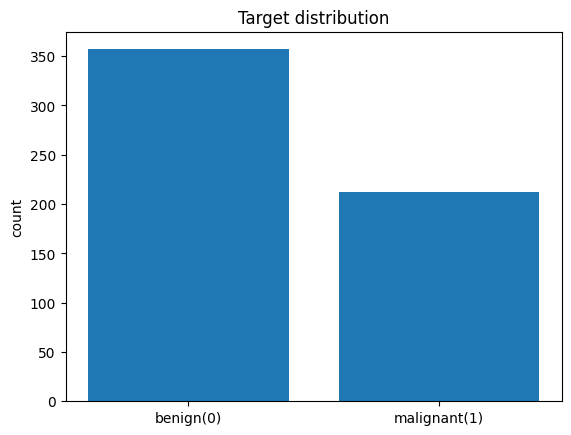

Counts:
benign(0): 357
malignant(1): 212


In [5]:
counts = y.value_counts().sort_index()
labels = ["benign(0)", "malignant(1)"]

plt.figure()
plt.bar(labels, counts.values)
plt.title("Target distribution")
plt.ylabel("count")
plt.show()

print("Counts:")
for lab, c in zip(labels, counts.values):
    print(f"{lab}: {c}")


### 5.2 Summary statistics

In [6]:
X.describe().T[['mean', 'std', 'min', '50%', 'max']].head(10)


,mean,std,min,50%,max
mean radius,14.127292,3.524049,6.98100,13.37000,28.11000
mean texture,19.289649,4.301036,9.71000,18.84000,39.28000
mean perimeter,91.969033,24.298981,43.79000,86.24000,188.50000
mean area,654.889104,351.914129,143.50000,551.10000,2501.00000
mean smoothness,0.096360,0.014064,0.05263,0.09587,0.16340
mean compactness,0.104341,0.052813,0.01938,0.09263,0.34540
mean concavity,0.088799,0.079720,0.00000,0.06154,0.42680
mean concave points,0.048919,0.038803,0.00000,0.03350,0.20120
mean symmetry,0.181162,0.027414,0.10600,0.17920,0.30400
mean fractal dimension,0.062798,0.007060,0.04996,0.06154,0.09744


### 5.3 Feature distributions 

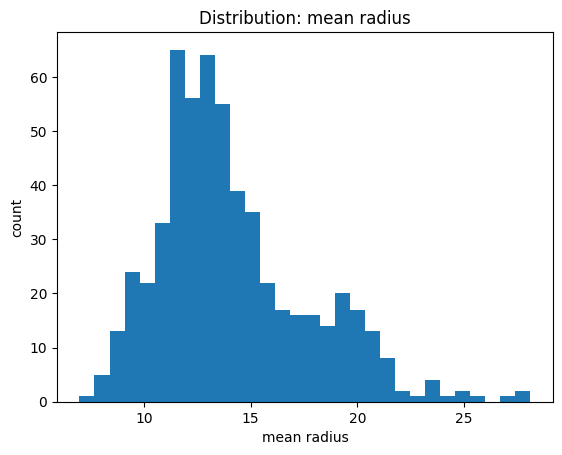

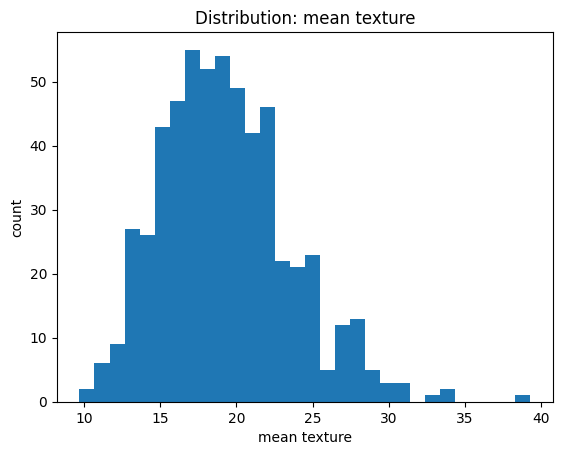

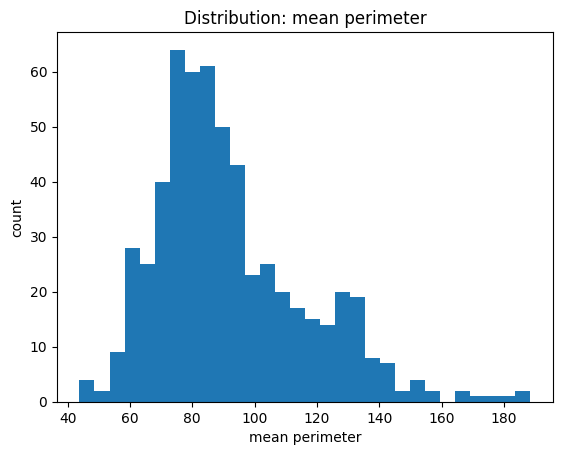

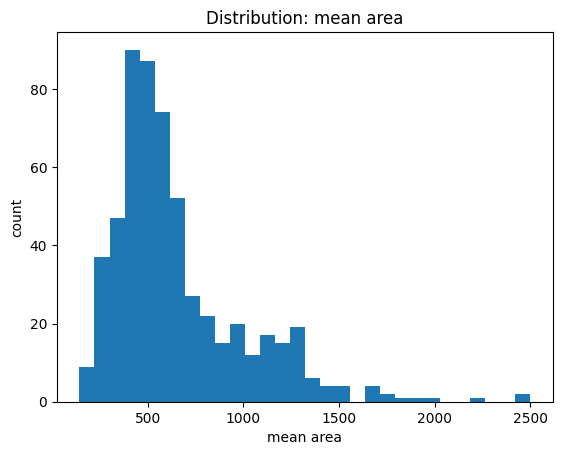

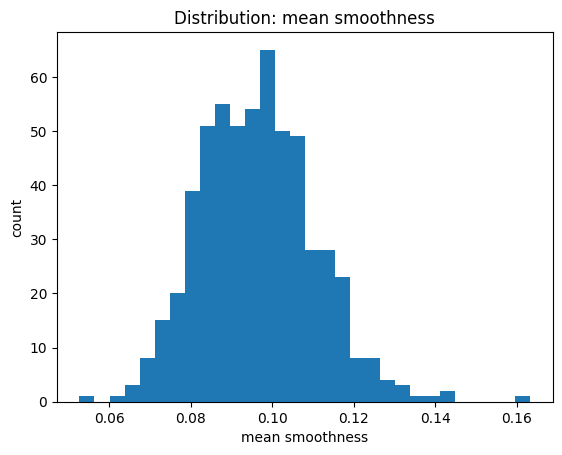

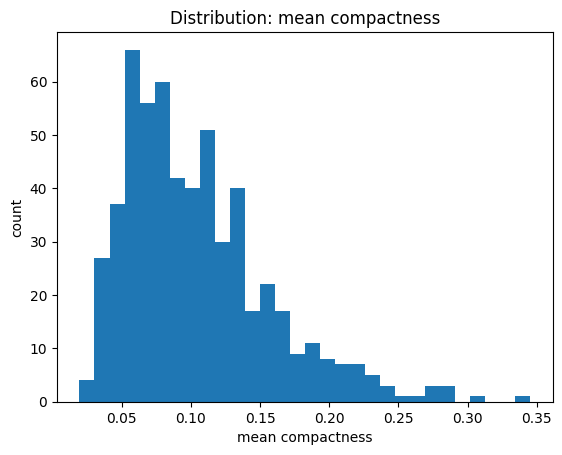

In [7]:
sample_features = [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
    "mean compactness",
]

for col in sample_features:
    plt.figure()
    plt.hist(X[col].values, bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()


### 5.4 Benign vs malignant means (top absolute differences)

In [8]:
df_tmp = X.copy()
df_tmp["target_malignant"] = y.values

mean_benign = df_tmp[df_tmp["target_malignant"] == 0].drop(columns=["target_malignant"]).mean()
mean_malign = df_tmp[df_tmp["target_malignant"] == 1].drop(columns=["target_malignant"]).mean()

diff = (mean_malign - mean_benign).abs().sort_values(ascending=False)
top = diff.head(12).index.tolist()

summary = pd.DataFrame({
    "mean_benign": mean_benign[top],
    "mean_malignant": mean_malign[top],
    "abs_diff": diff[top]
}).sort_values("abs_diff", ascending=False)

summary


,mean_benign,mean_malignant,abs_diff
worst area,558.899440,1422.286321,863.386881
mean area,462.790196,978.376415,515.586219
worst perimeter,87.005938,141.370330,54.364392
area error,21.135148,72.672406,51.537257
mean perimeter,78.075406,115.365377,37.289971
worst radius,13.379801,21.134811,7.755010
worst texture,23.515070,29.318208,5.803138
mean radius,12.146524,17.462830,5.316306
mean texture,17.914762,21.604906,3.690144
perimeter error,2.000321,4.323929,2.323608


### 5.5 Correlation heatmap

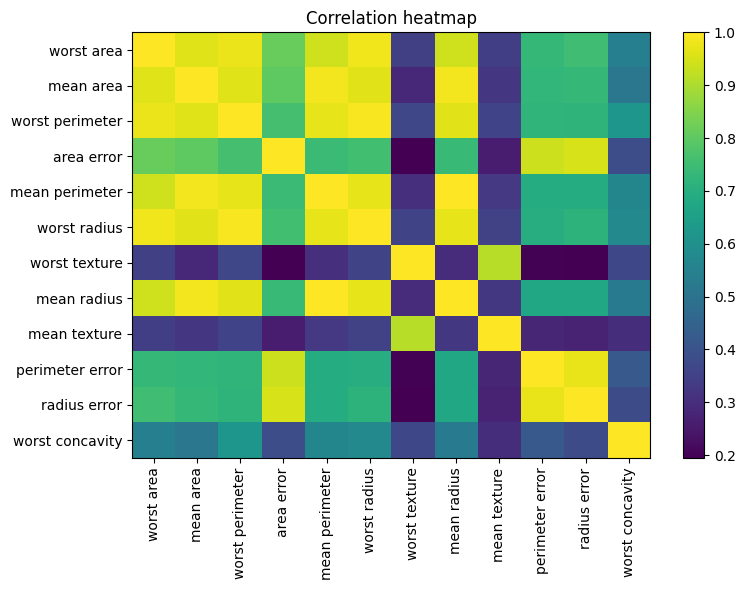

In [21]:
# Keep this lightweight: show correlations for top-difference features
corr_cols = top[:12]
corr = X[corr_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()


## 6. Preprocessing pipeline

In [10]:
numeric_features = list(X.columns)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop",
)

preprocessor


,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 7. Model selection

### 7.1 Baseline: Logistic Regression

Validation ROC-AUC (LogReg): 0.996


<Figure size 640x480 with 0 Axes>

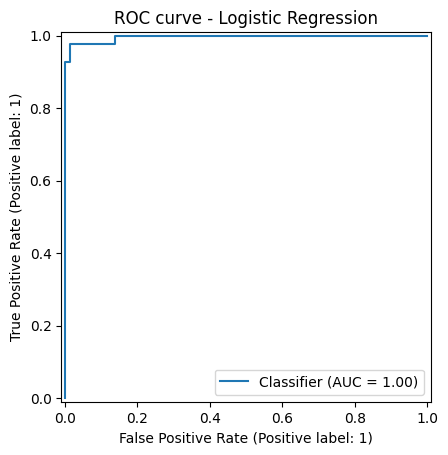

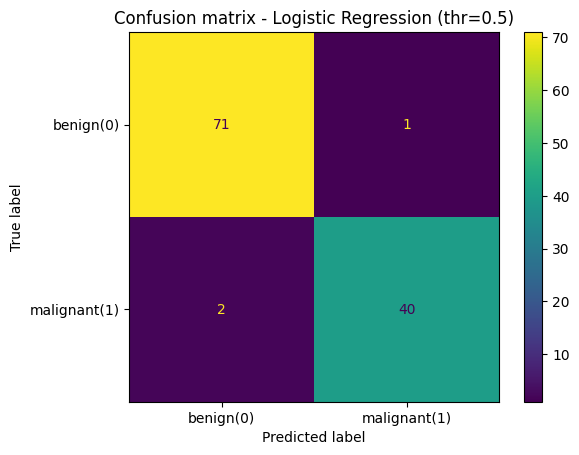

In [11]:
logreg_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear"))
])

logreg_pipe.fit(X_train, y_train)
val_proba = logreg_pipe.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print("Validation ROC-AUC (LogReg):", round(val_auc, 4))

plt.figure()
RocCurveDisplay.from_predictions(y_val, val_proba)
plt.title("ROC curve - Logistic Regression")
plt.show()

pred = (val_proba >= 0.5).astype(int)
cm = confusion_matrix(y_val, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["benign(0)", "malignant(1)"])
disp.plot()
plt.title("Confusion matrix - Logistic Regression (thr=0.5)")
plt.show()


### 7.2 Tree-based: Random Forest

Validation ROC-AUC (RF): 0.9929


<Figure size 640x480 with 0 Axes>

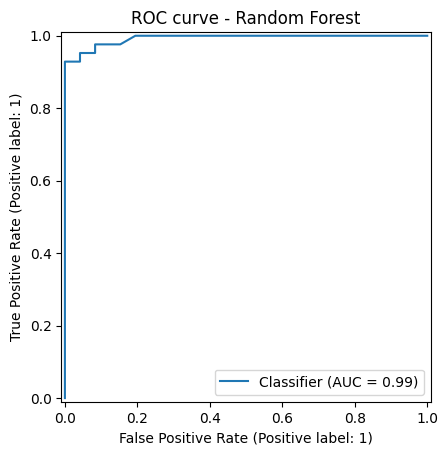

In [12]:
rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_pipe.fit(X_train, y_train)
val_proba = rf_pipe.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print("Validation ROC-AUC (RF):", round(val_auc, 4))

plt.figure()
RocCurveDisplay.from_predictions(y_val, val_proba)
plt.title("ROC curve - Random Forest")
plt.show()


### 7.3 Tree-based: Gradient Boosting 

Validation ROC-AUC (GB): 0.9947


<Figure size 640x480 with 0 Axes>

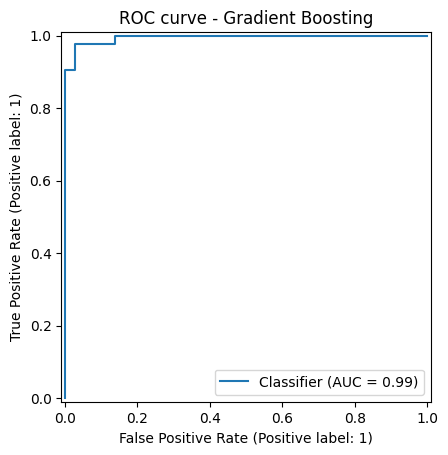

In [13]:
gb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_pipe.fit(X_train, y_train)
val_proba = gb_pipe.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print("Validation ROC-AUC (GB):", round(val_auc, 4))

plt.figure()
RocCurveDisplay.from_predictions(y_val, val_proba)
plt.title("ROC curve - Gradient Boosting")
plt.show()


## 8. Feature importance analysis

### 8.1 Logistic Regression coefficients (after scaling)

In [14]:
logreg_pipe.fit(X_train, y_train)
coef = logreg_pipe.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": numeric_features,
    "coef": coef,
    "abs_coef": np.abs(coef),
}).sort_values("abs_coef", ascending=False)

coef_df.head(20)


,feature,coef,abs_coef
21,worst texture,1.423806,1.423806
10,radius error,1.243632,1.243632
28,worst symmetry,1.059102,1.059102
7,mean concave points,0.954814,0.954814
13,area error,0.933406,0.933406
23,worst area,0.924092,0.924092
15,compactness error,-0.915840,0.915840
26,worst concavity,0.910627,0.910627
20,worst radius,0.896585,0.896585
6,mean concavity,0.790535,0.790535


### 8.2 Random Forest feature importances

In [15]:
rf_pipe.fit(X_train, y_train)
importances = rf_pipe.named_steps["model"].feature_importances_

imp_df = pd.DataFrame({
    "feature": numeric_features,
    "importance": importances
}).sort_values("importance", ascending=False)

imp_df.head(20)


,feature,importance
23,worst area,0.151412
27,worst concave points,0.126497
20,worst radius,0.093475
22,worst perimeter,0.083642
7,mean concave points,0.081082
2,mean perimeter,0.077126
0,mean radius,0.061990
6,mean concavity,0.050818
3,mean area,0.045916
26,worst concavity,0.030022


## 9. Parameter tuning with GridSearchCV

### 9.1 Tune Logistic Regression

In [16]:
logreg_tune = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear"))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
}

gs_lr = GridSearchCV(
    logreg_tune,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=0,
)
gs_lr.fit(X_train, y_train)

print("Best CV AUC:", round(gs_lr.best_score_, 4))
print("Best params:", gs_lr.best_params_)

val_proba = gs_lr.best_estimator_.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print("Val AUC:", round(val_auc, 4))


Best CV AUC: 0.9958
Best params: {'model__C': 10.0, 'model__penalty': 'l2'}
Val AUC: 0.9858


### 9.2 Tune Random Forest

In [17]:
rf_tune = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [1, 3, 5],
}

gs_rf = GridSearchCV(
    rf_tune,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=0,
)
gs_rf.fit(X_train, y_train)

print("Best CV AUC:", round(gs_rf.best_score_, 4))
print("Best params:", gs_rf.best_params_)

val_proba = gs_rf.best_estimator_.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print("Val AUC:", round(val_auc, 4))


Best CV AUC: 0.9901
Best params: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
Val AUC: 0.9944


## 10. Final choice

In [18]:
val_auc_lr = roc_auc_score(y_val, gs_lr.best_estimator_.predict_proba(X_val)[:, 1])
val_auc_rf = roc_auc_score(y_val, gs_rf.best_estimator_.predict_proba(X_val)[:, 1])

print("Val AUC tuned LogReg:", round(val_auc_lr, 4))
print("Val AUC tuned RF:", round(val_auc_rf, 4))

final_estimator = gs_rf.best_estimator_ if val_auc_rf >= val_auc_lr else gs_lr.best_estimator_
final_name = "rf" if final_estimator is gs_rf.best_estimator_ else "logreg"

print("Final model:", final_name)


Val AUC tuned LogReg: 0.9858
Val AUC tuned RF: 0.9944
Final model: rf
